# Advanced Lane Finding 


Stages:

0. Calculate Camera Calibration Matrix

Pipeline Stages:
1. Apply Distortion Correction
2. Perform appropriate colour transformations 
3. Adjust perspective to get Bird's Eye View
4. Perform Lane Detection
5. Calculate curvature
6. Warp back to original image
7. Output Image

0 is a pre-processing step, while 1-7 indicate our processing pipeline

In [1]:
## Import Libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
# Calculate Camera Distortion Matrix

# This is performed in a seperate notebook and the numbers brought in.
dist_pickle = pickle.load( open( "cameracal.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# undist = cv2.undistort(img, mtx, dist, None, mtx)

In [3]:
# Pipeline Steps

# 1 Distortion
def pipeline_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
# 2 Colour Transform

def pipeline_colourtransform(img):
    s_thresh=(170, 255)
    sx_thresh=(20, 100)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

In [5]:
# 3 & 7 Perspective transform to Bird's Eye

# Initially calculate the transforms
xsize = 1280
ysize = 720
    
# Points are TL, TR, BL, BR
src = np.float32([[598,445],[683,445],[272,675],[1052,675]])
dst = np.float32([[200,0],[xsize-200,0],[200,ysize],[xsize-200,ysize]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src) 

def pipeline_perspectivetransform(img):
    return cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)

def pipeline_inverttransform(img):
    return cv2.warpPerspective(img, Minv, (xsize,ysize), flags=cv2.INTER_LINEAR)

In [6]:
# 4 Fit the lines using a sliding window

# Polynomial fit values from the previous frame - global variables constantly updated
left_fit = np.array([ 1.77894152e-04, -2.37654883e-01,  2.89063021e+02])
right_fit = np.array([1.57028328e-05, -2.21887077e-02,  1.07018121e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global left_fit
    global right_fit
    
    ### Fit a second order polynomial to each with np.polyfit()
    ## Save to globals for use in the next frame    
       
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    margin = 125

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return result

In [7]:
#6 Calculate Curvature

def measure_curvature_metres():
    global left_fit
    global right_fit
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ym_per_pix = 15/720
    # Convert to metres
    y_eval = 720 * ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad



In [8]:
## Add Text to Image
def AddCaption(image, text):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) 
    fontScale = 2
    color = (255, 255, 255) 
    thickness = 2
    image = cv2.putText(image, text, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    return image

In [9]:
# PipeLine

def pipeline(img):
    
    # 1 Distortion - use previously calculated camera calibration
    orig = np.copy(img)
    img = pipeline_undistort(img)
    
    # 2 Colour Transforms
    # A seperate parameter scan showed a 
    img = pipeline_colourtransform(img)
    
    #img = combined_sobel(img)
    
    # 3 Adjust to Bird's Eye
    img = pipeline_perspectivetransform(img)
    
    # 4 Lane Detection
    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    img = search_around_poly(img)

    # 5 Calculate Curvature
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad = measure_curvature_metres()
    
    # Average curve 
    ave_curve = (left_curverad+right_curverad) / 2
    
    # 6 Warp back to Original
    img = pipeline_inverttransform(img)
 
    # 7 return image
    ## Add original image over the top.
    img = img + orig

     # Add Caption
    img = AddCaption(img, 'Radius of Curvature: %dm' % ave_curve) 
    
    return img
    

Having completed the pipeline now lets test in on the TEST IMAGES

test5.jpg


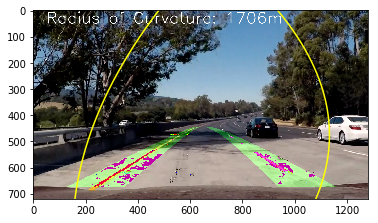

test6.jpg


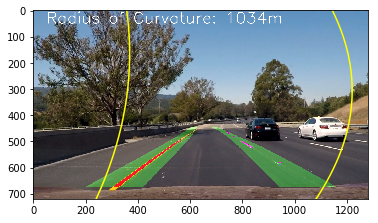

straight_lines2.jpg


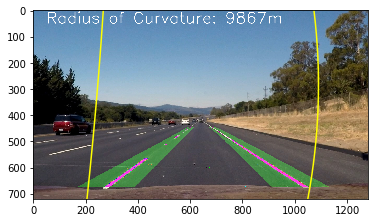

straight_lines1.jpg


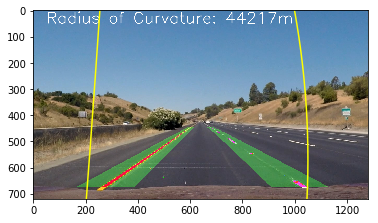

test3.jpg


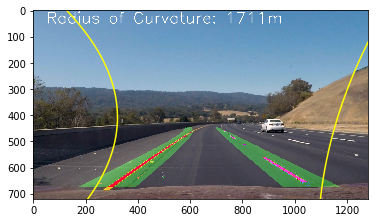

test4.jpg


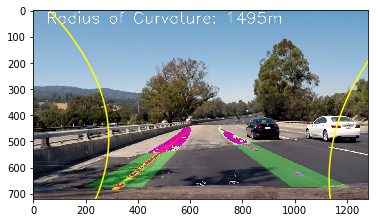

test1.jpg


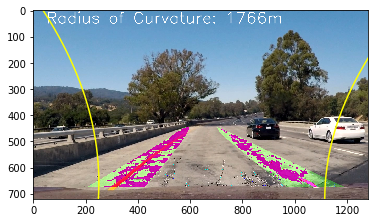

test2.jpg


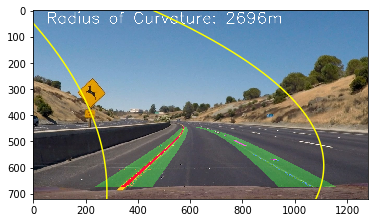

In [10]:
# Run Pipeline on all the TEST Images

for i, filename in enumerate(os.listdir("test_images/")):
#filename = 'test2.jpg'  
# Load Image and process
    print(filename)
    image = mpimg.imread("test_images/" + filename)
    outimage = pipeline(image)
    # Save Image
    #cv2.imwrite('output_images/' + filename, cv2.cvtColor(outimage, cv2.COLOR_RGB2BGR))
    plt.imshow(outimage)
    plt.show()

In [ ]:
## VIDEO TEST

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = pipeline(image)
    
    return result

output = 'project_video_processed.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 38%|███▊      | 474/1261 [01:37<02:42,  4.85it/s]